In [3]:
import pandas as pd
import pymongo
import requests
import time
import json
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix

In [4]:
def games_in_a_month(df, player, month):
    return len(df['games'][player][month][0]['games'])

def is_in_fist_30_days(df, player, month, game):
    '''returns True if game was played within the first 30 days of signing up'''
    seconds_in_a_month = 2629743
    month_from_date_joined = df['joined'][player] + seconds_in_a_month
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return month_from_date_joined > time_of_game

def is_in_fourth_month(df, player, month, game):
    '''returns the count of games played in the in the 4th month since sign up'''
    seconds_in_a_month = 2629743
    three_months_from_date_joined = df['joined'][player] + (3 * seconds_in_a_month)
    four_months_from_date_joined = df['joined'][player] + (3.5 * seconds_in_a_month)
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return (time_of_game > three_months_from_date_joined) and (time_of_game < four_months_from_date_joined)

def games_in_first_month(df, player, month, game):
    '''returns a count of how many games were played by a user in the first 30 days since signing up'''
    games = 0
    if is_in_fist_30_days(df, player, month, game):
        games += 1
    return games

def rated_games(df, player, month, game):
    '''returns True if game was rated and it was played within the first 30 days of signing up'''
    if is_in_fist_30_days(df, player, month, game):
        return str(df['games'][player][month][0]['games'][game]['rated'])
    else:
        return 'invalid'
    
def time_class_games(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['time_class']
    else:
        return 'invalid'
    
def rules_games(df, player, month, game):
    '''returns chess variation if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['rules']
    else:
        return 'invalid'
    
def eco_games(df, player, month, game):
    '''returns the eco code for opening played if the game was played in the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['eco'][31:].split('-')[0]
    else:
        return 'invalid'

def results_games(df, player, month, game):
    '''returns the result of the each game played'''
    result_for_white = df['games'][player][month][0]['games'][game]['white']['result']
    result_for_black = df['games'][player][month][0]['games'][game]['black']['result']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return result_for_white
        else:
            return result_for_black
    else:
        return 'invalid'

def rating_games(df, player, month, game):
    '''returns the result of the each game played'''
    rating_for_white = df['games'][player][month][0]['games'][game]['white']['rating']
    rating_for_black = df['games'][player][month][0]['games'][game]['black']['rating']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return int(rating_for_white)
        else:
            return int(rating_for_black)
    else:
        return 0

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    '''
    player_idxes = range(df.shape[0])
    for player in player_idxes:
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        ratings = [0,]
        fourth_month_games = 0
        first_month_games = 0
        for month in range(5):
            try:
                for game in range(games_in_a_month(df, player, month)):
                    if is_in_fourth_month(df, player, month, game):
                        fourth_month_games += 1
                    if is_in_fist_30_days(df, player, month, game):
                        first_month_games += 1
                        try:
                            rated.append(rated_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(df, player, month, game))
                        except KeyError:
                            continue
    #                     try:
    #                         eco.append(eco_games(df, player, month, game))
    #                     except KeyError:
    #                         continue
                        try:
                            results.append(results_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            ratings.append(rating_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            first_month_games += games_in_first_month(df, player, month, game)
                        except KeyError:
                            continue
            except (KeyError, IndexError):
                continue

        df.loc[player, 'fourth_month_games'] = fourth_month_games
        df.loc[player, 'first_month_games'] = first_month_games
        df.loc[player, 'highest_rating'] = max(ratings)
        df.loc[player, 'lowest_rating'] = min(ratings)
#         df.loc[player, 'minimum_rating'] = min([rating for rating in ratings if rating > 0])
        
        make_columns(rated, df, player)
        make_columns(rules, df, player)
#         make_columns(eco, df, player)
        make_columns(results, df, player)
            
        
def add_features(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        df: dataframe with all feature columns and target column
    '''
    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in the fourth month since signup
    df['inactive'] = df['fourth_month_games'].apply(lambda x: 1 if x == 0 else 0)

    #create columns has_name, has_location, has_avatar
    df['has_name'] = df['name'].apply(lambda x: 0 if x != x else 1)
    df['has_location'] = df['location'].apply(lambda x: 0 if x != x else 1)
    df['has_avatar'] = df['avatar'].apply(lambda x: 0 if x != x else 1)

    #make a basic account type column
    df['is_basic'] = df['status'].apply(lambda x: 1 if x == 'basic' else 0)

    #make a premium account type column
    df['is_premium'] = df['status'].apply(lambda x:  1 if x == 'premium' else 0)
    
    #win percentage
#     df['win_percentage'] = df['win'] / df['first_month_games']
    
#     #rated percentage
#     df['rated_percentage'] = df['rated'] / df['first_month_games']
    return df.fillna(0)
    
    
def make_X_y(df):
    '''returns:
            X: all important feature columns
            y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)'''
    #assign X and y variables
    y = df['inactive']
    
    X = df[['first_month_games', 'chess', 'resigned', 'checkmated', 'timeout',
       'abandoned', 'timevsinsufficient', 'stalemate', 'insufficient',
       'unrated', 'repetition', 'agreed', 'bughouse', 'crazyhouse',
       'kingofthehill', 'chess960', 'threecheck', 'has_name', 'has_location', 'has_avatar',
       'is_basic', 'is_premium', 'highest_rating']]
    
    return (X, y)

def create_df_from_mongo():
    mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
    db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

    print('import data from mongoDB to pandas dataframe')
    
    #get data from mongoDB and put into dataframe
    df = pd.DataFrame(list(db['players'].find()))

    #remove duplicate users by player_id
    df.drop_duplicates(subset='player_id', inplace=True)

    # #reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df

/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


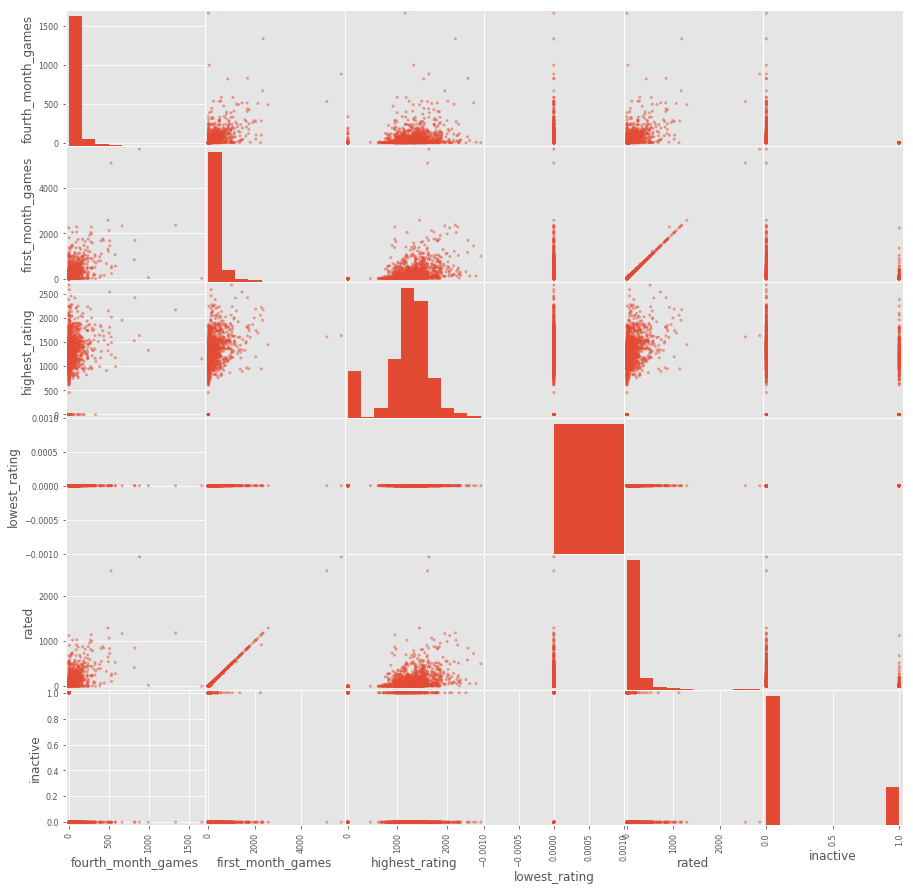

In [22]:
scatter_matrix(all_feature_df[['fourth_month_games', 'first_month_games', 'highest_rating',
       'lowest_rating', 'rated','inactive']], figsize=(15, 15));

In [7]:
all_feature_df.columns

Index(['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz', 'chess_bullet',
       'chess_daily', 'chess_rapid', 'country', 'followers', 'games', 'joined',
       'last_online', 'location', 'name', 'player_id', 'status', 'url',
       'username', 'fourth_month_games', 'first_month_games', 'highest_rating',
       'lowest_rating', 'rated', 'chess', 'checkmated', 'resigned', 'timeout',
       'win', 'abandoned', 'timevsinsufficient', 'stalemate', 'insufficient',
       'unrated', 'repetition', 'agreed', 'bughouse', 'crazyhouse',
       'kingofthehill', 'chess960', 'threecheck', 'bughousepartnerlose',
       '50move', 'inactive', 'has_name', 'has_location', 'has_avatar',
       'is_basic', 'is_premium'],
      dtype='object')

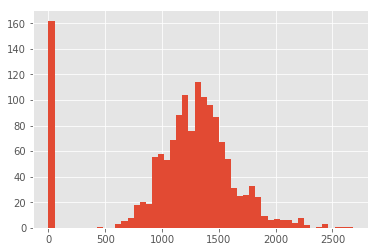

In [8]:
all_feature_df.highest_rating.hist(bins=50)

In [23]:
zero_rating_df = all_feature_df[all_feature_df['highest_rating'] == 0]

In [31]:
zero_rating_df['username']

2                 0ldtower
7               1103chucky
23                     1ln
30               209rayzor
43              321collins
57                70281381
63                  7teal7
64                  804659
72         a_e_s_t_h_e_t_e
85              aaronbel88
89            aaronwingert
90                aaverbuj
95                 abcde45
100            abelskinner
104                 aboo12
105        abottleofbutter
110              abramdb82
112               abridger
115               abula001
125             adamcrouch
126                adammes
139       admiralexcalibur
162         aggritobiaggio
166               aherbo25
170     ahmed4677tarek5678
186               ajpietka
204            alan-taylor
217          albertorosado
221            alcmorrison
229       alexanderheifetz
               ...        
1146        yannistsamados
1167             fettiloso
1174           chrissturch
1178                 dmorr
1181               his1981
1182              vikramke
1

In [29]:
zero_rating_df.loc[7,:]['games']

[[{'games': []}],
 [{'games': []}],
 [{'games': [{'black': {'@id': 'https://api.chess.com/pub/player/subarctic',
      'rating': 1321,
      'result': 'win',
      'username': 'SubArctic'},
     'end_time': 1520719782,
     'fen': '2B1kb1r/4p2p/p5p1/5p2/3Pn3/q3PQ1P/3B1PP1/5RK1 w k -',
     'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2018.03.10"]\n[Round "-"]\n[White "1103chucky"]\n[Black "SubArctic"]\n[Result "0-1"]\n[WhiteElo "1209"]\n[BlackElo "1321"]\n[TimeControl "180"]\n[Termination "SubArctic won on time"]\n[StartTime "22:09:42"]\n[EndDate "2018.03.10"]\n[EndTime "22:09:42"]\n[Link "https://www.chess.com/live/game/2669068671"]\n\n1. Nf3 {[%clk 0:02:57]} 1... f6 {[%clk 0:02:56]} 2. d4 {[%clk 0:02:51]} 2... d5 {[%clk 0:02:55]} 3. e3 {[%clk 0:02:49]} 3... Bg4 {[%clk 0:02:53]} 4. c4 {[%clk 0:02:46]} 4... c6 {[%clk 0:02:50]} 5. Nc3 {[%clk 0:02:43]} 5... Na6 {[%clk 0:02:46]} 6. Bd3 {[%clk 0:02:32]} 6... Nb4 {[%clk 0:02:42]} 7. Bb1 {[%clk 0:02:26]} 7... f5 {[%clk 0:02:36]} 

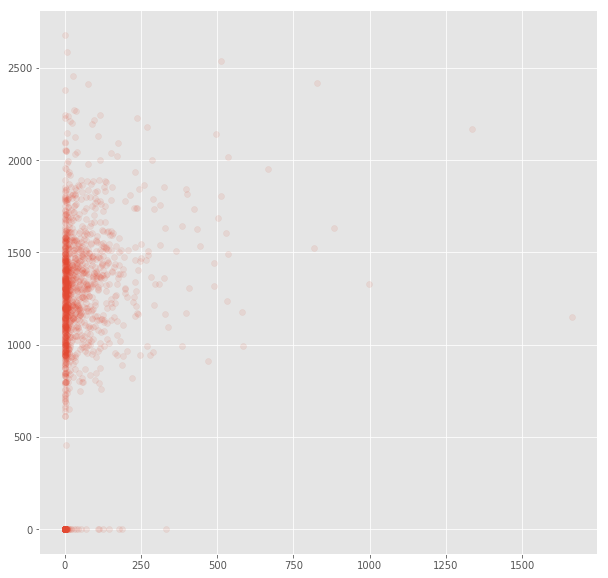

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(all_feature_df.fourth_month_games, all_feature_df.highest_rating, alpha=.1)

In [32]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

print('import data from mongoDB to pandas dataframe')
#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players'].find()))

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

# #reset the index
df.reset_index(drop=True, inplace=True)

all_feature_df = add_features(df)

import data from mongoDB to pandas dataframe


In [4]:
sample_df = df[:100].copy()

In [6]:
fill_df = add_features(sample_df)


# #create features and target dataframes
X, y = make_X_y(fill_df)

# #make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print(cross_val_score(random_forest_testrun, X_test, y_test))

NameError: name 'sample_df' is not defined

In [89]:
sample_df.describe()

,followers,joined,last_online,player_id,fourth_month_games,first_month_games,rated,chess,checkmated,resigned,...,50move,inactive,has_name,has_location,has_avatar,is_basic,is_premium,highest_rating,rated,unrated
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,85.000000,87.000000,75.000000,70.000000,...,0.0,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,85.000000,11.000000
mean,2.260000,1.515952e+09,1.526282e+09,4.232060e+07,60.370000,238.520000,139.847059,134.804598,26.120000,33.785714,...,NaN,0.260000,0.640000,0.040000,0.43000,0.930000,0.070000,1121.970000,139.847059,3.545455
std,3.823426,7.619154e+05,5.980598e+04,2.852295e+05,95.397484,353.688971,184.242626,183.196034,30.545031,47.116535,...,NaN,0.440844,0.482418,0.196946,0.49757,0.256432,0.256432,527.982638,184.242626,2.544156
min,0.000000,1.514778e+09,1.526118e+09,4.188282e+07,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.515304e+09,1.526256e+09,4.207942e+07,0.000000,7.500000,10.000000,9.500000,3.000000,3.000000,...,NaN,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,946.000000,10.000000,2.000000
50%,1.000000,1.515970e+09,1.526309e+09,4.232895e+07,13.000000,73.000000,55.000000,54.000000,14.000000,14.000000,...,NaN,0.000000,1.000000,0.000000,0.00000,1.000000,0.000000,1200.500000,55.000000,3.000000
75%,2.250000,1.516552e+09,1.526324e+09,4.254176e+07,103.000000,354.500000,226.000000,225.000000,39.000000,49.750000,...,NaN,1.000000,1.000000,0.000000,1.00000,1.000000,0.000000,1490.250000,226.000000,4.500000
max,20.000000,1.517418e+09,1.526335e+09,4.287271e+07,534.000000,1740.000000,870.000000,870.000000,133.000000,276.000000,...,NaN,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,2230.000000,870.000000,9.000000


In [33]:
# mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
# db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

# print('import data from mongoDB to pandas dataframe')
# #get data from mongoDB and put into dataframe
# df = pd.DataFrame(list(db['players'].find()))

# print('done importing from mongoDB')

# #remove duplicate users by player_id
# df.drop_duplicates(subset='player_id', inplace=True)

# # #reset the index
# df.reset_index(drop=True, inplace=True)

print('now making features and target')

# make features and target
add_features(df)

print('making target and features')
# create features and target dataframes
X, y = make_X_y(df.fillna(0))

# #make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

now making features and target
making target and features
0.8149427816901409


In [10]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)
gradient_y_predict = gradient_boost.predict_proba(X_test)

print(roc_auc_score(y_test, gradient_y_predict[:, 1]))
# print(cross_val_score(gradient_boost, X_test, y_test, cv=20))

0.8193661971830987


In [34]:
logistic_model = LogisticRegressionCV()
logistic_model.fit(X, y)
logistic_y_predict = logistic_model.predict_proba(X)

print(roc_auc_score(y, logistic_y_predict[:, 1]))
# print(cross_val_score(logistic_model, X_test, y_test, cv=20))

0.792225910035349


In [49]:
list(zip(logistic_model.coef_[0], list(X.columns)))

[(-0.0027787353544813983, 'first_month_games'),
 (-0.001426966223801421, 'chess'),
 (0.002298500378185971, 'resigned'),
 (-0.010405040238032801, 'checkmated'),
 (0.010352791551013037, 'timeout'),
 (-0.004270393196583532, 'abandoned'),
 (0.0014284830069456016, 'timevsinsufficient'),
 (-0.0006139983903326771, 'stalemate'),
 (0.0008499984542338438, 'insufficient'),
 (0.00042685250794097495, 'unrated'),
 (0.00042685250794097495, 'unrated'),
 (-0.0002984025132023109, 'repetition'),
 (-0.0011781580932808116, 'agreed'),
 (-0.0009043587660929336, 'bughouse'),
 (0.0006698003855928274, 'crazyhouse'),
 (-0.00041228957289718047, 'kingofthehill'),
 (0.0003838428921051092, 'chess960'),
 (0.00018734735024132803, 'threecheck'),
 (-0.0014435033507875243, 'has_name'),
 (-0.0006142315460451459, 'has_location'),
 (-0.0024517106543798205, 'has_avatar'),
 (0.00023093408886535168, 'is_basic'),
 (-0.00021352654355200117, 'is_premium'),
 (-0.0012834262369288416, 'highest_rating')]

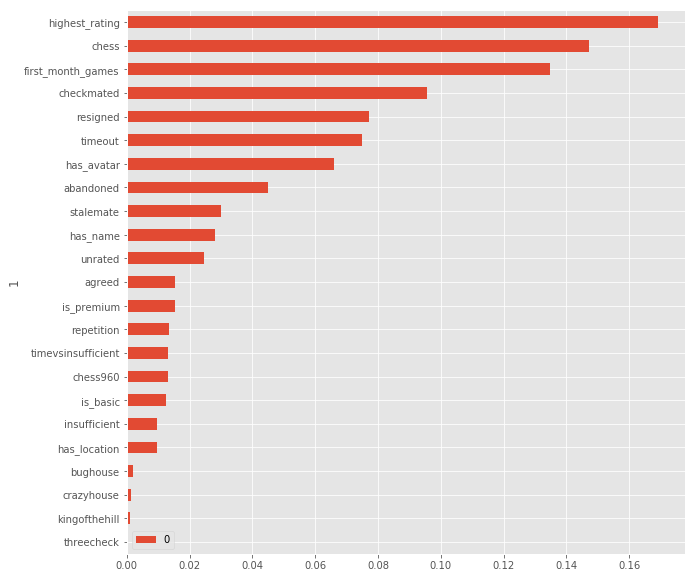

In [34]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

values, features = rf_best_features(X_test, y_test, 26)
plot_best_features(values, features)

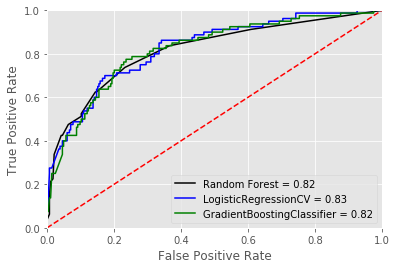

In [13]:
fig, ax = plt.subplots()

rand_y_pred = random_forest_testrun.predict_proba(X_test)

rand_fpr, rand_tpr, rand_threshold = roc_curve(y_test, rand_y_pred[:,1])
rand_area_under_curve = auc(rand_fpr, rand_tpr)

logistic_y_pred = logistic_model.predict_proba(X_test)

logistic_fpr, logistic_tpr, logistic_threshold = roc_curve(y_test, logistic_y_pred[:,1])
logistic_area_under_curve = auc(logistic_fpr, logistic_tpr)

gradient_y_pred = gradient_boost.predict_proba(X_test)

gradient_fpr, gradient_tpr, gradient_threshold = roc_curve(y_test, gradient_y_pred[:,1])
gradient_area_under_curve = auc(gradient_fpr, gradient_tpr)

ax.plot(rand_fpr, rand_tpr, 'k', label = f'Random Forest = {rand_area_under_curve:.2f}')
ax.plot(logistic_fpr, logistic_tpr, 'b', label = f'LogisticRegressionCV = {logistic_area_under_curve:.2f}')
ax.plot(gradient_fpr, gradient_tpr, 'g', label = f'GradientBoostingClassifier = {gradient_area_under_curve:.2f}')

ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC')
plt.show()


# # plot_roc([random_forest_testrun, gradient_boost, logistic_model], X_test, y_test)
# plot_roc(random_forest_testrun, X_test, y_test)
# plot_roc(gradient_boost, X_test, y_test)
# plot_roc(logistic_model, X_test, y_test)